In [18]:
run_training = False
retrain = False
find_learning_rate = False
import os, sys
from os import listdir

In [48]:
files = os.listdir("D:/99_Project_Data/00_BreastCancer_Images/breast-histopathology-images")
#path = "D:/99_Project_Data/00_BreastCancer_Images/breast-histopathology-images"
#dirs = os.listdir(path)

#for file in dirs:
#   print(file)

print(len(files))

280


In [49]:
path = os.getcwd() 

In [50]:
files[0:10]

['10253',
 '10254',
 '10255',
 '10256',
 '10257',
 '10258',
 '10259',
 '10260',
 '10261',
 '10262']

In [51]:
files = listdir("D:/99_Project_Data/00_BreastCancer_Images/breast-histopathology-images/IDC_regular_ps50_idx5/")
len(files)

279

In [25]:
base_path = "D://99_Project_Data//00_BreastCancer_Images//breast-histopathology-images//IDC_regular_ps50_idx5/"
folder = listdir(base_path)
len(folder)

279

In [52]:
list = os.listdir("D:/99_Project_Data/00_BreastCancer_Images/breast-histopathology-images/IDC_regular_ps50_idx5/") # dir is your directory path
number_files = len(list)
print(number_files)

279


In [53]:
total_images = 0
for n in range(len(folder)):
    patient_id = folder[n]
    for c in [0,1]:
        patient_path = base_path + patient_id
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        total_images += len(subfiles)

In [54]:
total_images

277524

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns
sns.set()
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, CyclicLR
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight

from glob import glob
from skimage.io import imread

import time
import copy
from tqdm import tqdm_notebook as tqdm

In [56]:
data = pd.DataFrame(index=np.arange(0,total_images), columns=["patient_id","path","target"])

k = 0
for n in range(len(folder)):
    patient_id = folder[n]
    patient_path = base_path + patient_id
    for c in [0,1]:
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        for m in range(len(subfiles)):
            image_path = subfiles[m]
            data.iloc[k]["path"] = class_path + image_path
            data.iloc[k]["target"] = c
            data.iloc[k]["patient_id"] = patient_id
            k += 1        
    

In [57]:
data[data['target']==1]

,patient_id,path,target
479,10253,D://99_Project_Data//00_BreastCancer_Images//b...,1
480,10253,D://99_Project_Data//00_BreastCancer_Images//b...,1
481,10253,D://99_Project_Data//00_BreastCancer_Images//b...,1
482,10253,D://99_Project_Data//00_BreastCancer_Images//b...,1
483,10253,D://99_Project_Data//00_BreastCancer_Images//b...,1
...,...,...,...
277519,9383,D://99_Project_Data//00_BreastCancer_Images//b...,1
277520,9383,D://99_Project_Data//00_BreastCancer_Images//b...,1
277521,9383,D://99_Project_Data//00_BreastCancer_Images//b...,1
277522,9383,D://99_Project_Data//00_BreastCancer_Images//b...,1


In [59]:
data.shape

(277524, 3)

In [61]:
data.groupby("patient_id").target.size()

patient_id
10253     549
10254     848
10255     272
10256     468
10257     635
         ... 
9346     1361
9347      410
9381     1326
9382     1652
9383      564
Name: target, Length: 279, dtype: int64

In [62]:
data.groupby("patient_id").target.value_counts()

patient_id  target
10253       0          479
            1           70
10254       0          772
            1           76
10255       0          181
                      ... 
9381        1          128
9382        0         1306
            1          346
9383        0          494
            1           70
Name: target, Length: 558, dtype: int64

In [63]:
cancer_perc = data.groupby("patient_id").target.value_counts()/ data.groupby("patient_id").target.size()
cancer_perc = cancer_perc.unstack() # unstack => pivotting 

In [64]:
cancer_perc.head()

target,0,1
patient_id,,
10253,0.872495,0.127505
10254,0.910377,0.089623
10255,0.665441,0.334559
10256,0.750000,0.250000
10257,0.672441,0.327559


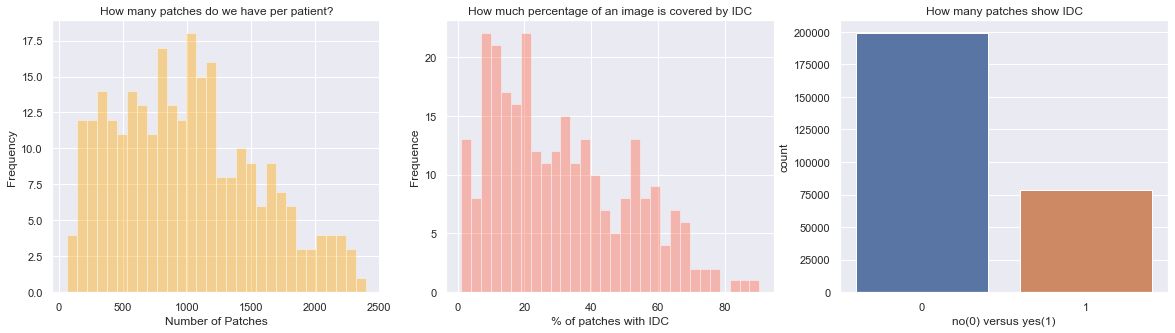

In [85]:
fig, ax = plt.subplots(1,3, figsize=(20,5))
sns.distplot(data.groupby("patient_id").size(), ax=ax[0], color="Orange", kde = False, bins=30)
ax[0].set_xlabel("Number of Patches")
ax[0].set_ylabel("Frequency")
ax[0].set_title("How many patches do we have per patient?")
sns.distplot(cancer_perc.iloc[:,1]*100, ax=ax[1], color='Tomato', kde=False, bins=30)
ax[1].set_xlabel("% of patches with IDC") # IDC stands for 'Invasive Ductal Carcinoma'
ax[1].set_ylabel("Frequence")
ax[1].set_title("How much percentage of an image is covered by IDC")
sns.countplot(data.target,  ax=ax[2])
ax[2].set_xlabel("no(0) versus yes(1)")
ax[2].set_title("How many patches show IDC");

In [86]:
data.target = data.target.astype(np.int)

In [87]:
pos_selection = np.random.choice(data[data.target == 1].index.values, size=50, replace=False)
neg_selection = np.random.choice(data[data.target == 0].index.values, size=50, replace=False)

#### Cancer Patches

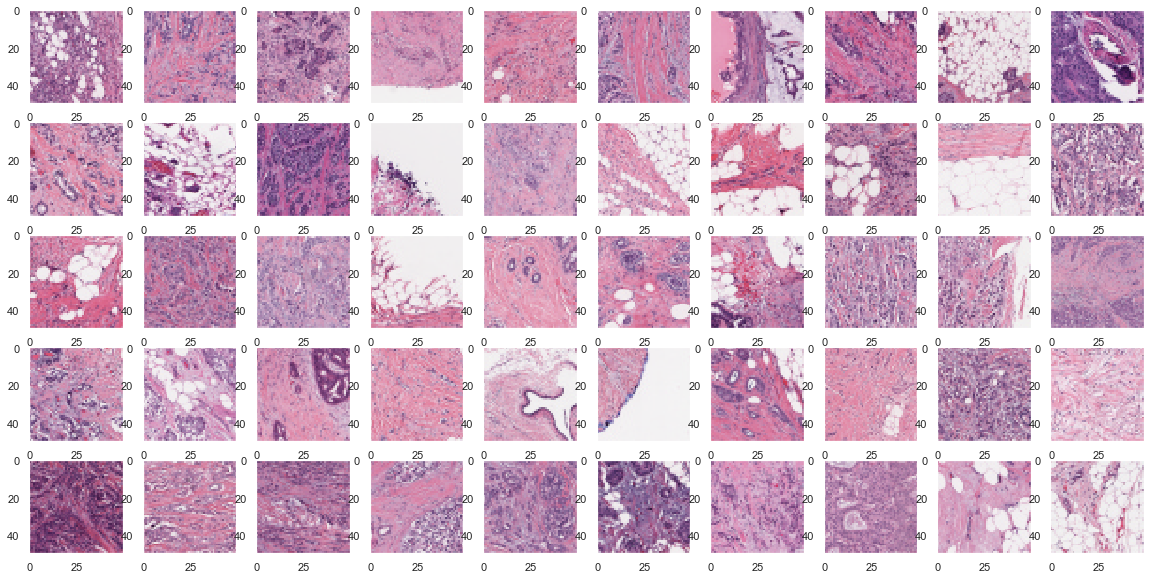

In [90]:
fig, ax = plt.subplots(5,10, figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = pos_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

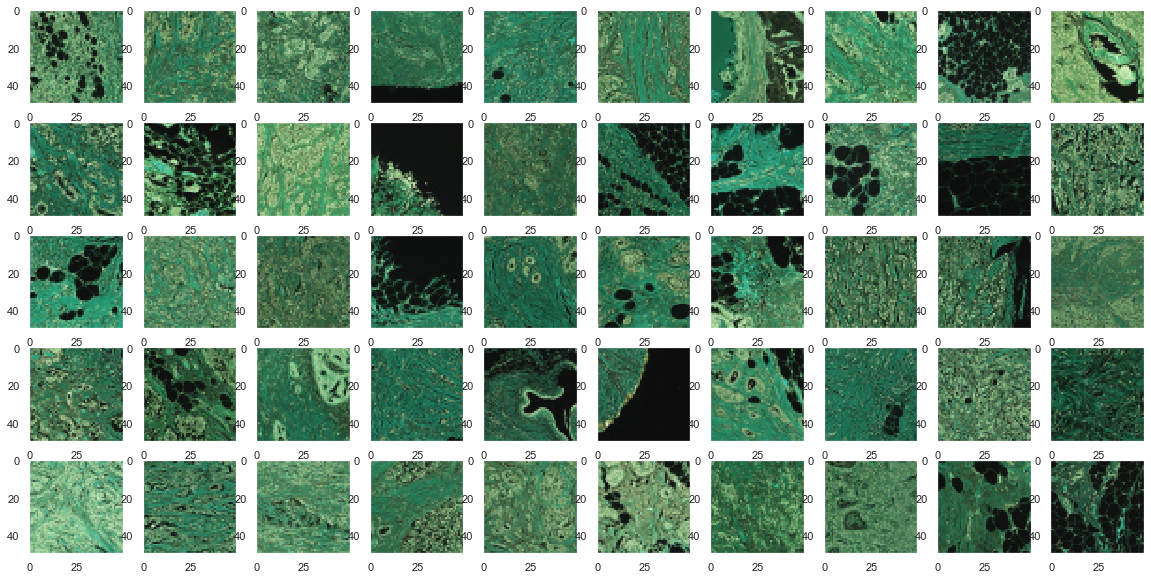

In [104]:
fig, ax = plt.subplots(5,10, figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = pos_selection[m + 10*n]
        image = Image.open(data.loc[idx, "path"])
        inverted_image = PIL.ImageOps.invert(image)
        ax[n,m].imshow(inverted_image)
        ax[n,m].grid(False)
        
        

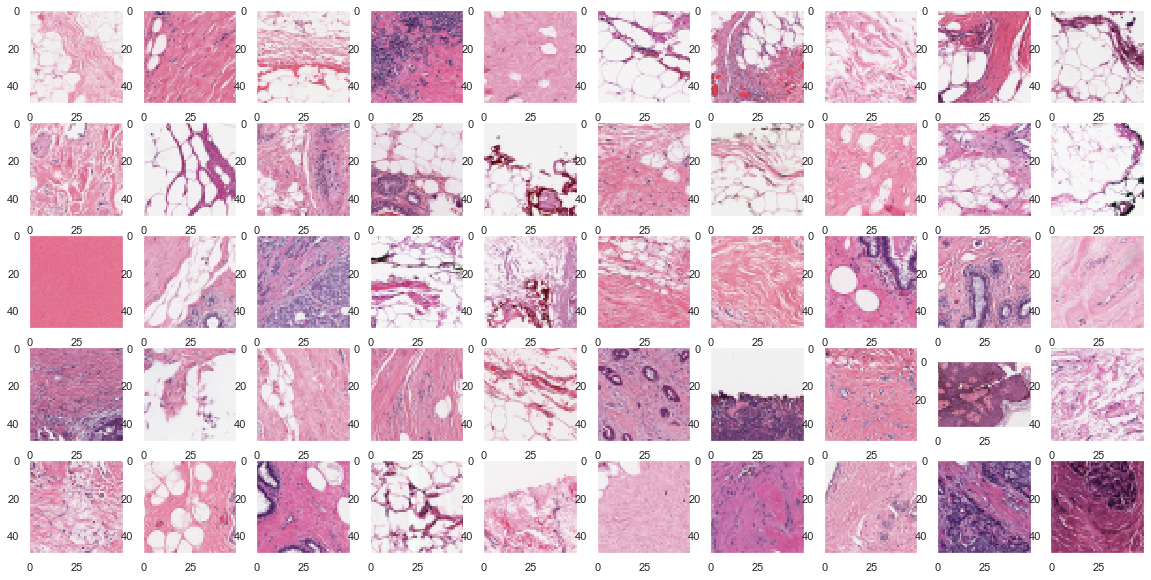

In [89]:

fig, ax = plt.subplots(5,10, figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = neg_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

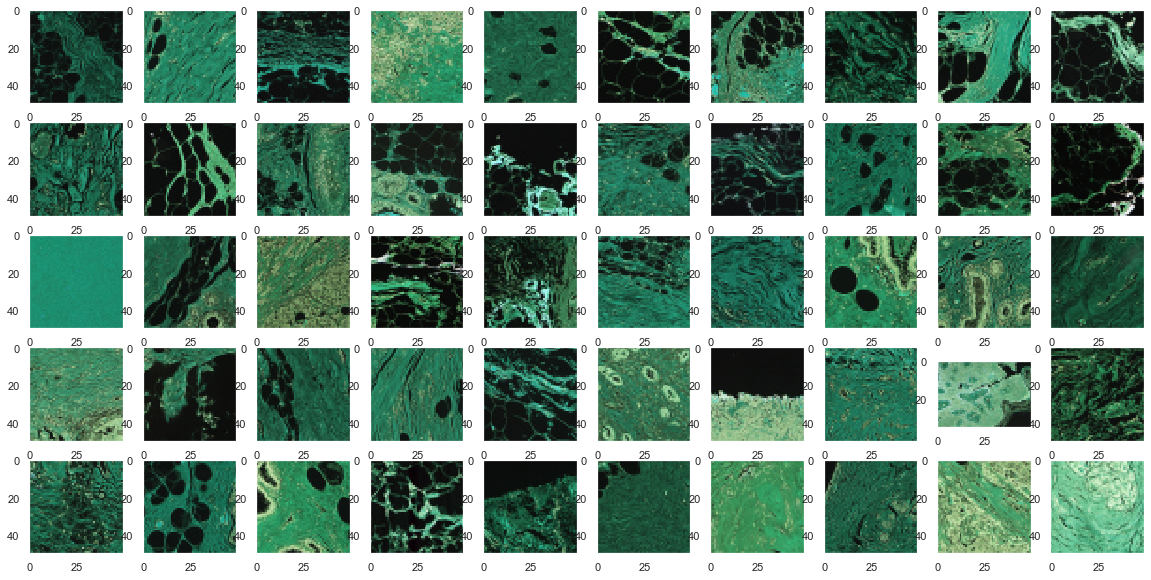

In [105]:
fig, ax = plt.subplots(5,10, figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = neg_selection[m + 10*n]
        image = Image.open(data.loc[idx, "path"])
        inverted_image = PIL.ImageOps.invert(image)
        ax[n,m].imshow(inverted_image)
        ax[n,m].grid(False)